In [1]:
import os
# import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

# np.set_printoptions(precision=3, suppress=True)

2023-10-09 19:45:28.277256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 19:45:28.277300: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 19:45:28.277329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 19:45:28.285141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
 
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}


VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

In [ ]:
# pip install seaborn

Text(0.5, 1.0, 'Mask')

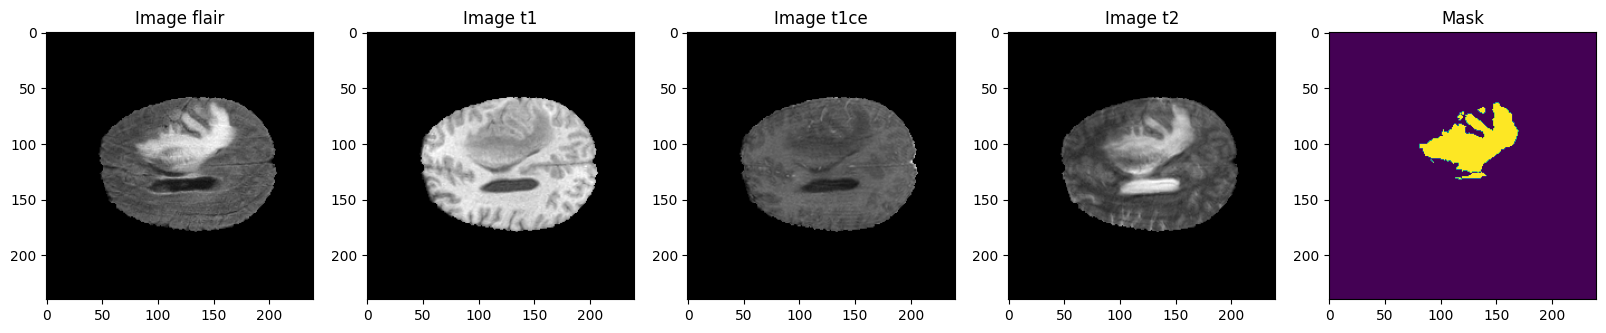

In [3]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


**Show segments of tumor using different effects**

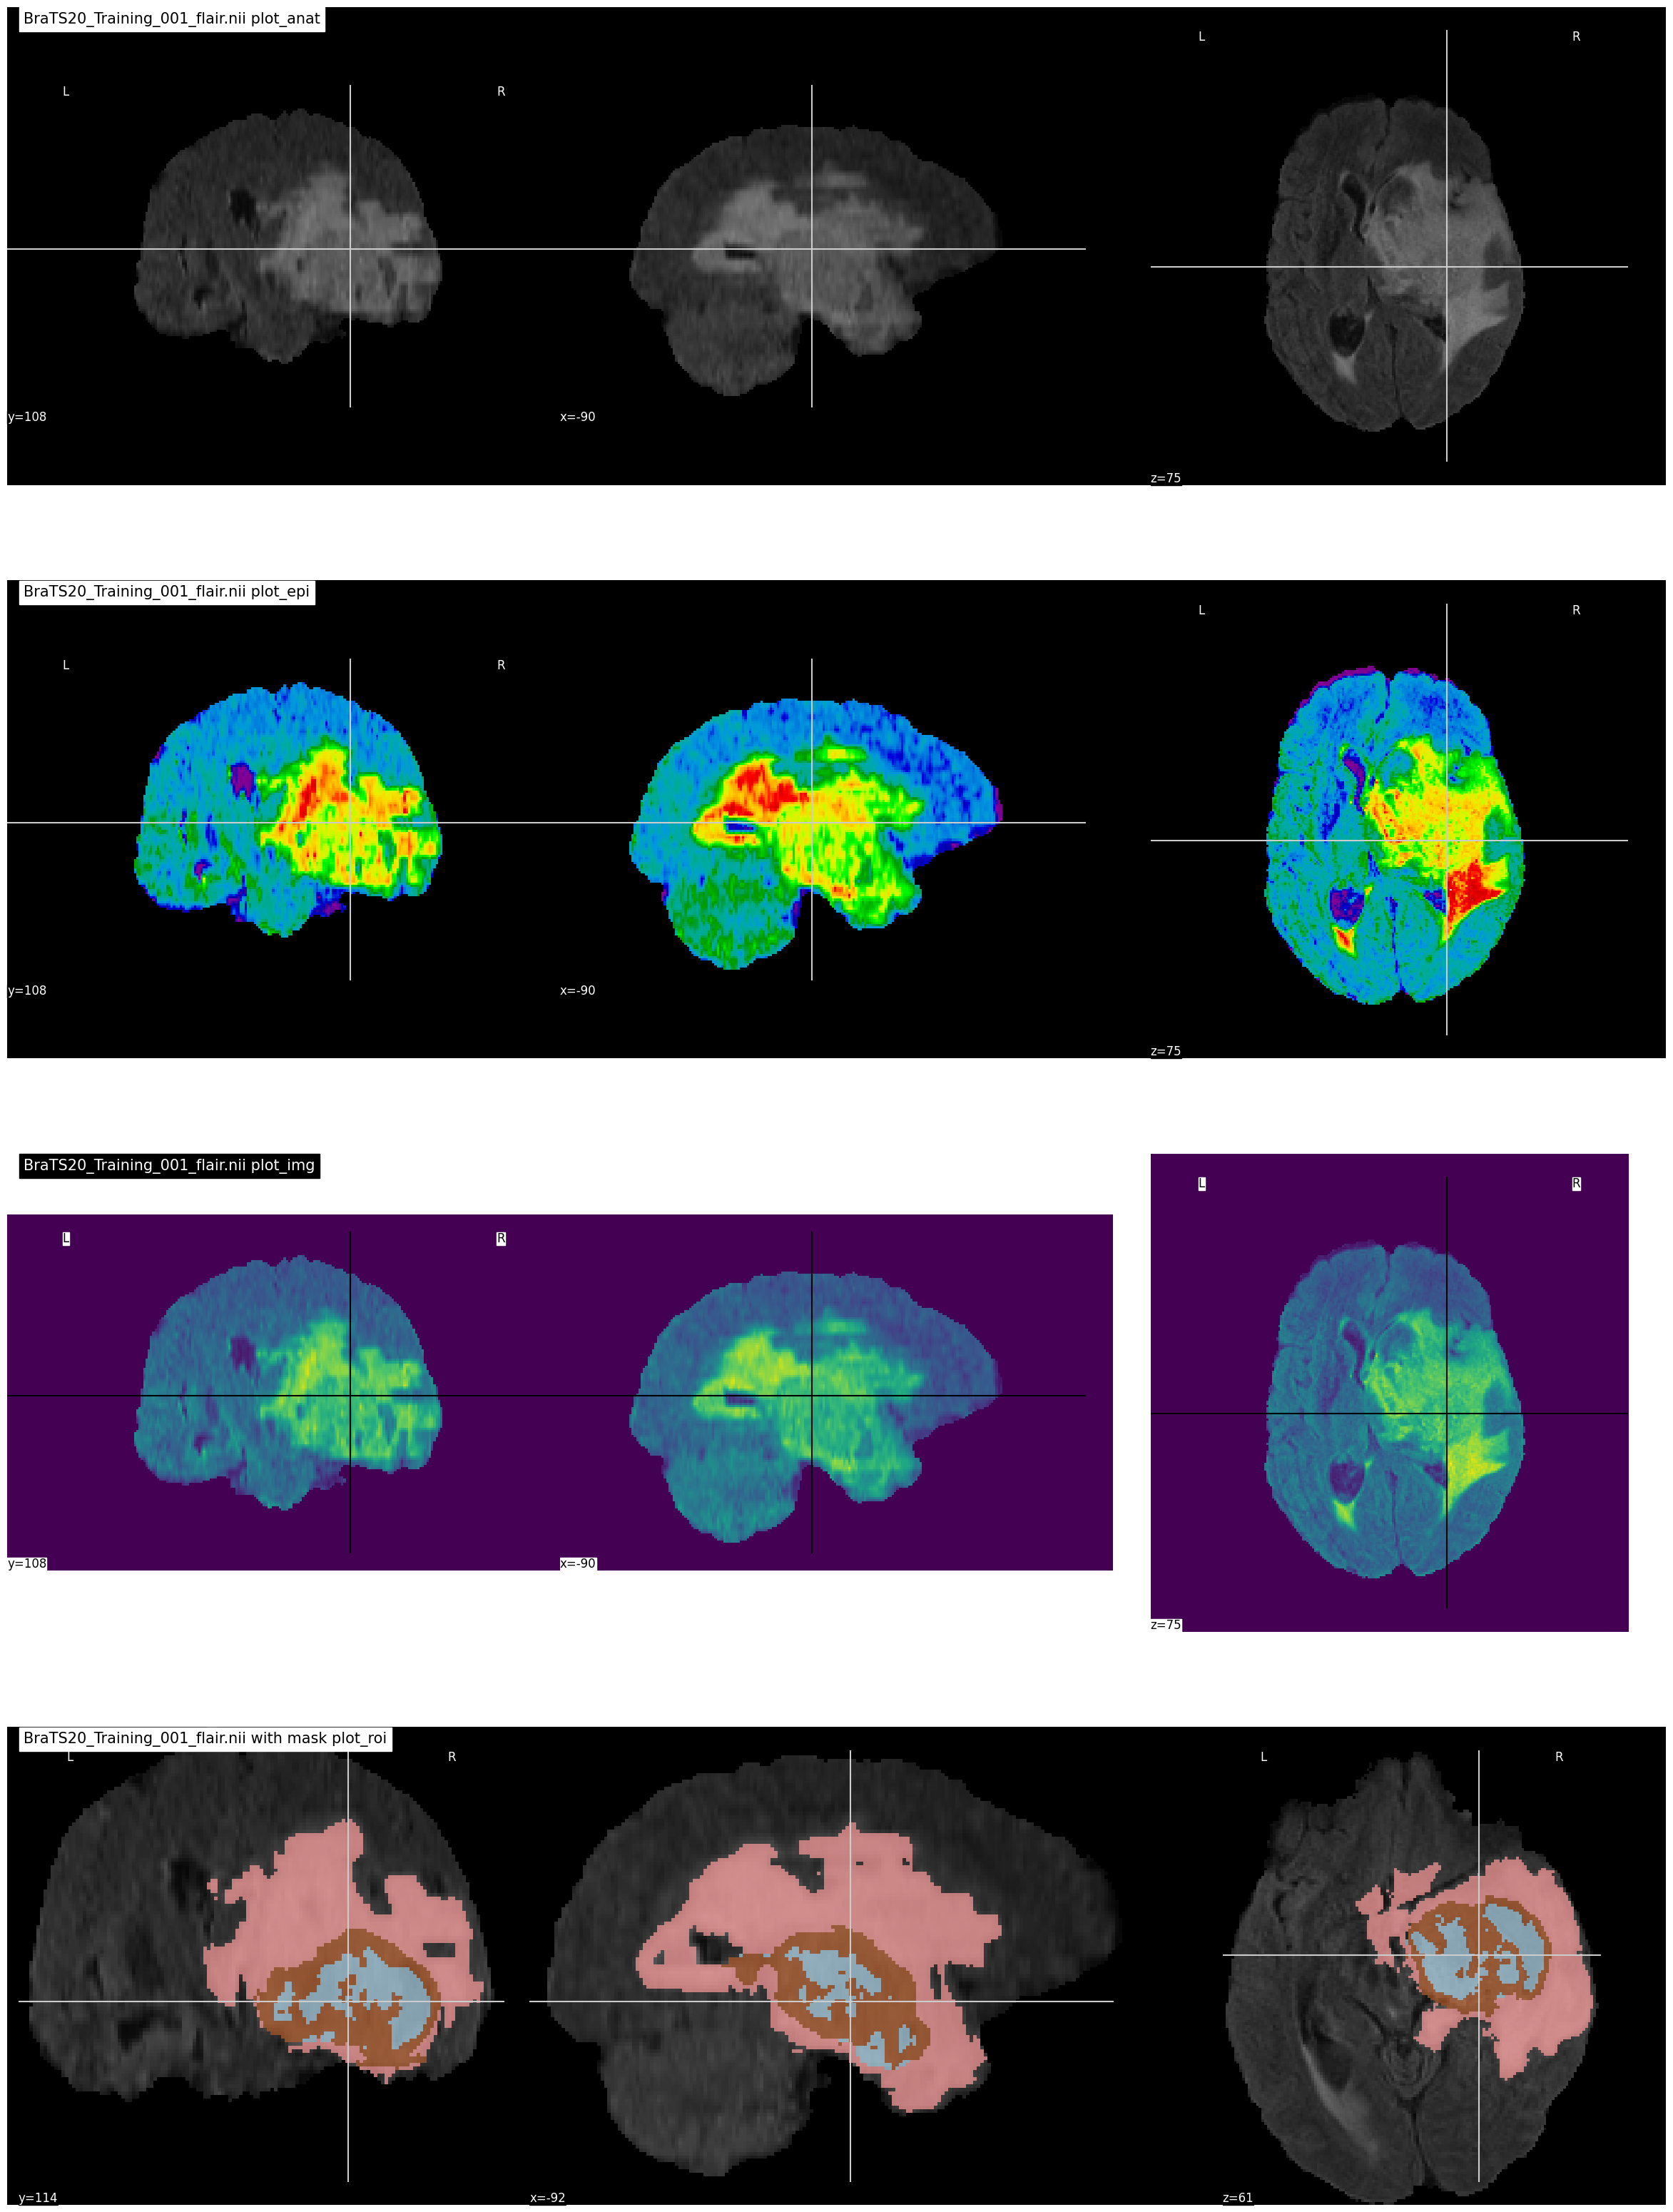

In [4]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [4]:

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
     
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [5]:
IMG_SIZE=128
IMG_SIZE

128

In [6]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal

def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def build_model():
    size = 128
    num_filters = [16, 32, 48, 64]
    inputs = Input(shape=(size, size, 2))
    skip_x = []
    x = inputs

    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    for i, f, in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    x = Conv2D(4, (1, 1), padding="same",kernel_initializer=he_normal())(x)
    x = Activation("softmax")(x)

    return Model(inputs, x)


model = build_model()
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
  


2023-10-09 19:45:40.800119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22208 MB memory:  -> device: 0, name: Tesla M40 24GB, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-10-09 19:45:40.801586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22208 MB memory:  -> device: 1, name: Tesla M40 24GB, pci bus id: 0000:82:00.0, compute capability: 5.2


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         304       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

**model architecture**


# Load data


In [7]:

train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

**Override Keras sequence DataGenerator class**

In [8]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
       
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = resize(flair[:, :, j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = resize(ce[:, :, j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                # X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                # X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
        
        y[y==4] = 3;
        y[(y < 0) | (y > 3)] = np.random.randint(0, 4, np.sum((y < 0) | (y > 3)))
        
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [9]:
from skimage.transform import resize

**Number of data used**
for training / testing / validation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


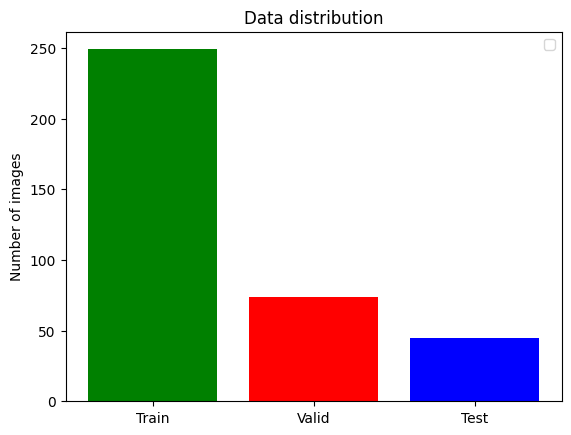

In [10]:

def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint


weights_dir = "model_weights/"

if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

checkpoint_files = [f for f in os.listdir(weights_dir) if f.startswith("model_weights_epoch")]
if checkpoint_files:
    checkpoint_files.sort(key=lambda x: int(x.split("_")[2].split(".")[0][-2:]))
    last_checkpoint = checkpoint_files[-1]
    last_epoch = int(last_checkpoint.split("_")[2].split(".")[0][-2:])
    model.load_weights(os.path.join(weights_dir, last_checkpoint))
    print(f"Resuming training from epoch {last_epoch}")
else:
    last_epoch = 0

checkpoint = ModelCheckpoint(
    os.path.join(weights_dir, f"model_weights_epoch{{epoch:02d}}.h5"),
    save_best_only=True
)

history = model.fit(
    training_generator,
    epochs=50,  
    initial_epoch=last_epoch,  
    steps_per_epoch=len(train_ids),
    callbacks=[checkpoint],
    validation_data = valid_generator
)

model.save("unet_final_model.h5")


Resuming training from epoch 50


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Visualize the training process**

In [13]:
model = keras.models.load_model('../Minor Project/unet_final_model.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

# Prediction examples 

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

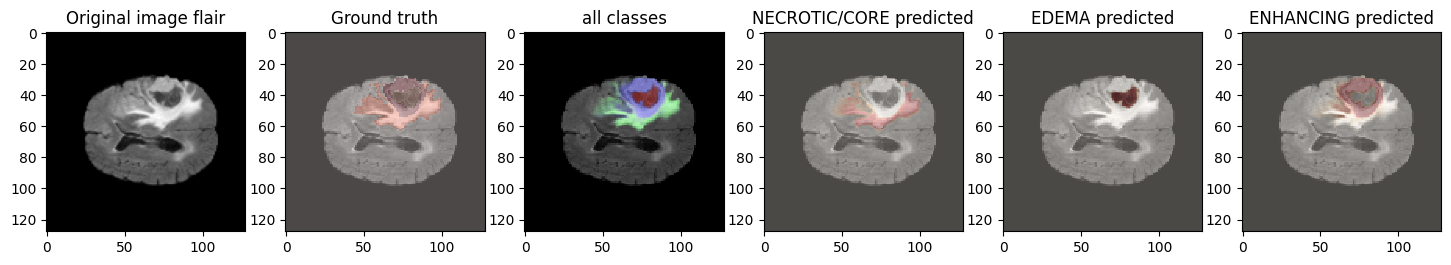

4/4 [==============================] - 0s 22ms/step


<Figure size 1800x5000 with 0 Axes>

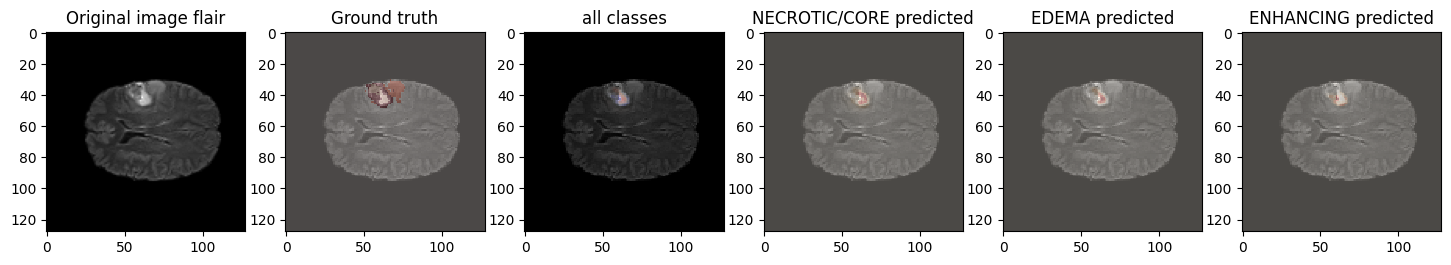

In [21]:
from PIL import Image
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 


    
    for j in range(VOLUME_SLICES):
         X[j,:,:,0] = resize(flair[:, :, j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
         X[j,:,:,1] = resize(ce[:, :, j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        # = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        # X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    slice_to_resize = gt[:, :, start_slice + VOLUME_START_AT]
    image = Image.fromarray(slice_to_resize)
    resized_image = image.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
    curr_gt = np.array(resized_image)
    # curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    

showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[6][-3:])



# Evaluation

4/4 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

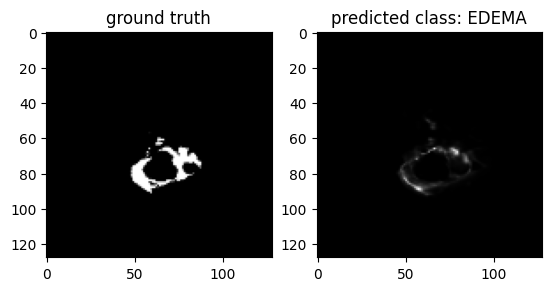

In [17]:
case = case=test_ids[1][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 
eval_class = 2



gt[gt != eval_class] = 1  

resized_gt = resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [19]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
print("Evaluate on test data")
model.evaluate(test_generator, batch_size=100)


Evaluate on test data
45/45 [==============================] - 22s 412ms/step - loss: 0.0746 - accuracy: 0.9823 - mean_io_u_4: 0.4576 - dice_coef: 0.5095 - precision: 0.9827 - sensitivity: 0.9816 - specificity: 0.9942 - dice_coef_necrotic: 0.4843 - dice_coef_edema: 0.3736 - dice_coef_enhancing: 0.5218


[0.07455320656299591,
 0.9823360443115234,
 0.4575767517089844,
 0.5095095038414001,
 0.9827160239219666,
 0.9815911054611206,
 0.9942383766174316,
 0.4842829704284668,
 0.3735646605491638,
 0.5217735171318054]

In [1]:
pip install nbmerge

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for nbmerge: filename=nbmerge-0.0.4-py2.py3-none-any.whl size=6429 sha256=28d500cac879ff7ddb3886aacbb69e548e802dc7816ac01a6553a2f242362034
  Stored in directory: c:\users\medap\appdata\local\pip\cache\wheels\05\7d\2c\44d9b357515a0b4f972f5438115face603f69e8c70233ddc1a
Successfully built nbmerge
Note: you may need to restart the kernel to use updated packages.


In [5]:
nbmerge "brain-tumour-image-segmentation(1)(1).ipynb" "brain-tumour-image-segmentation(3).ipynb" > "brain_tumour_final.ipynb"

SyntaxError: invalid syntax (3413259751.py, line 1)

In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

In [2]:
 
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}


VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

Text(0.5, 1.0, 'Mask')

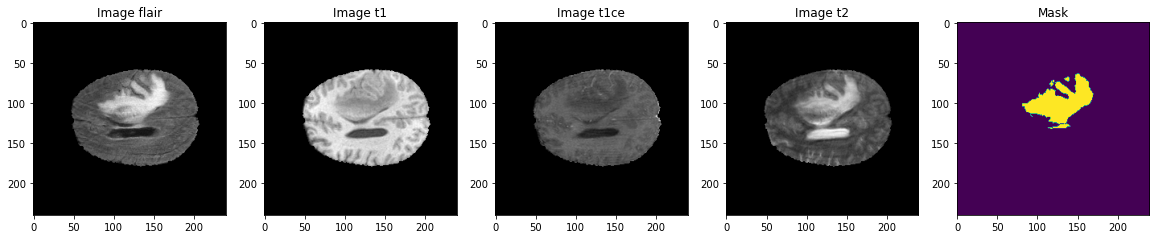

In [3]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


**Show segments of tumor using different effects**

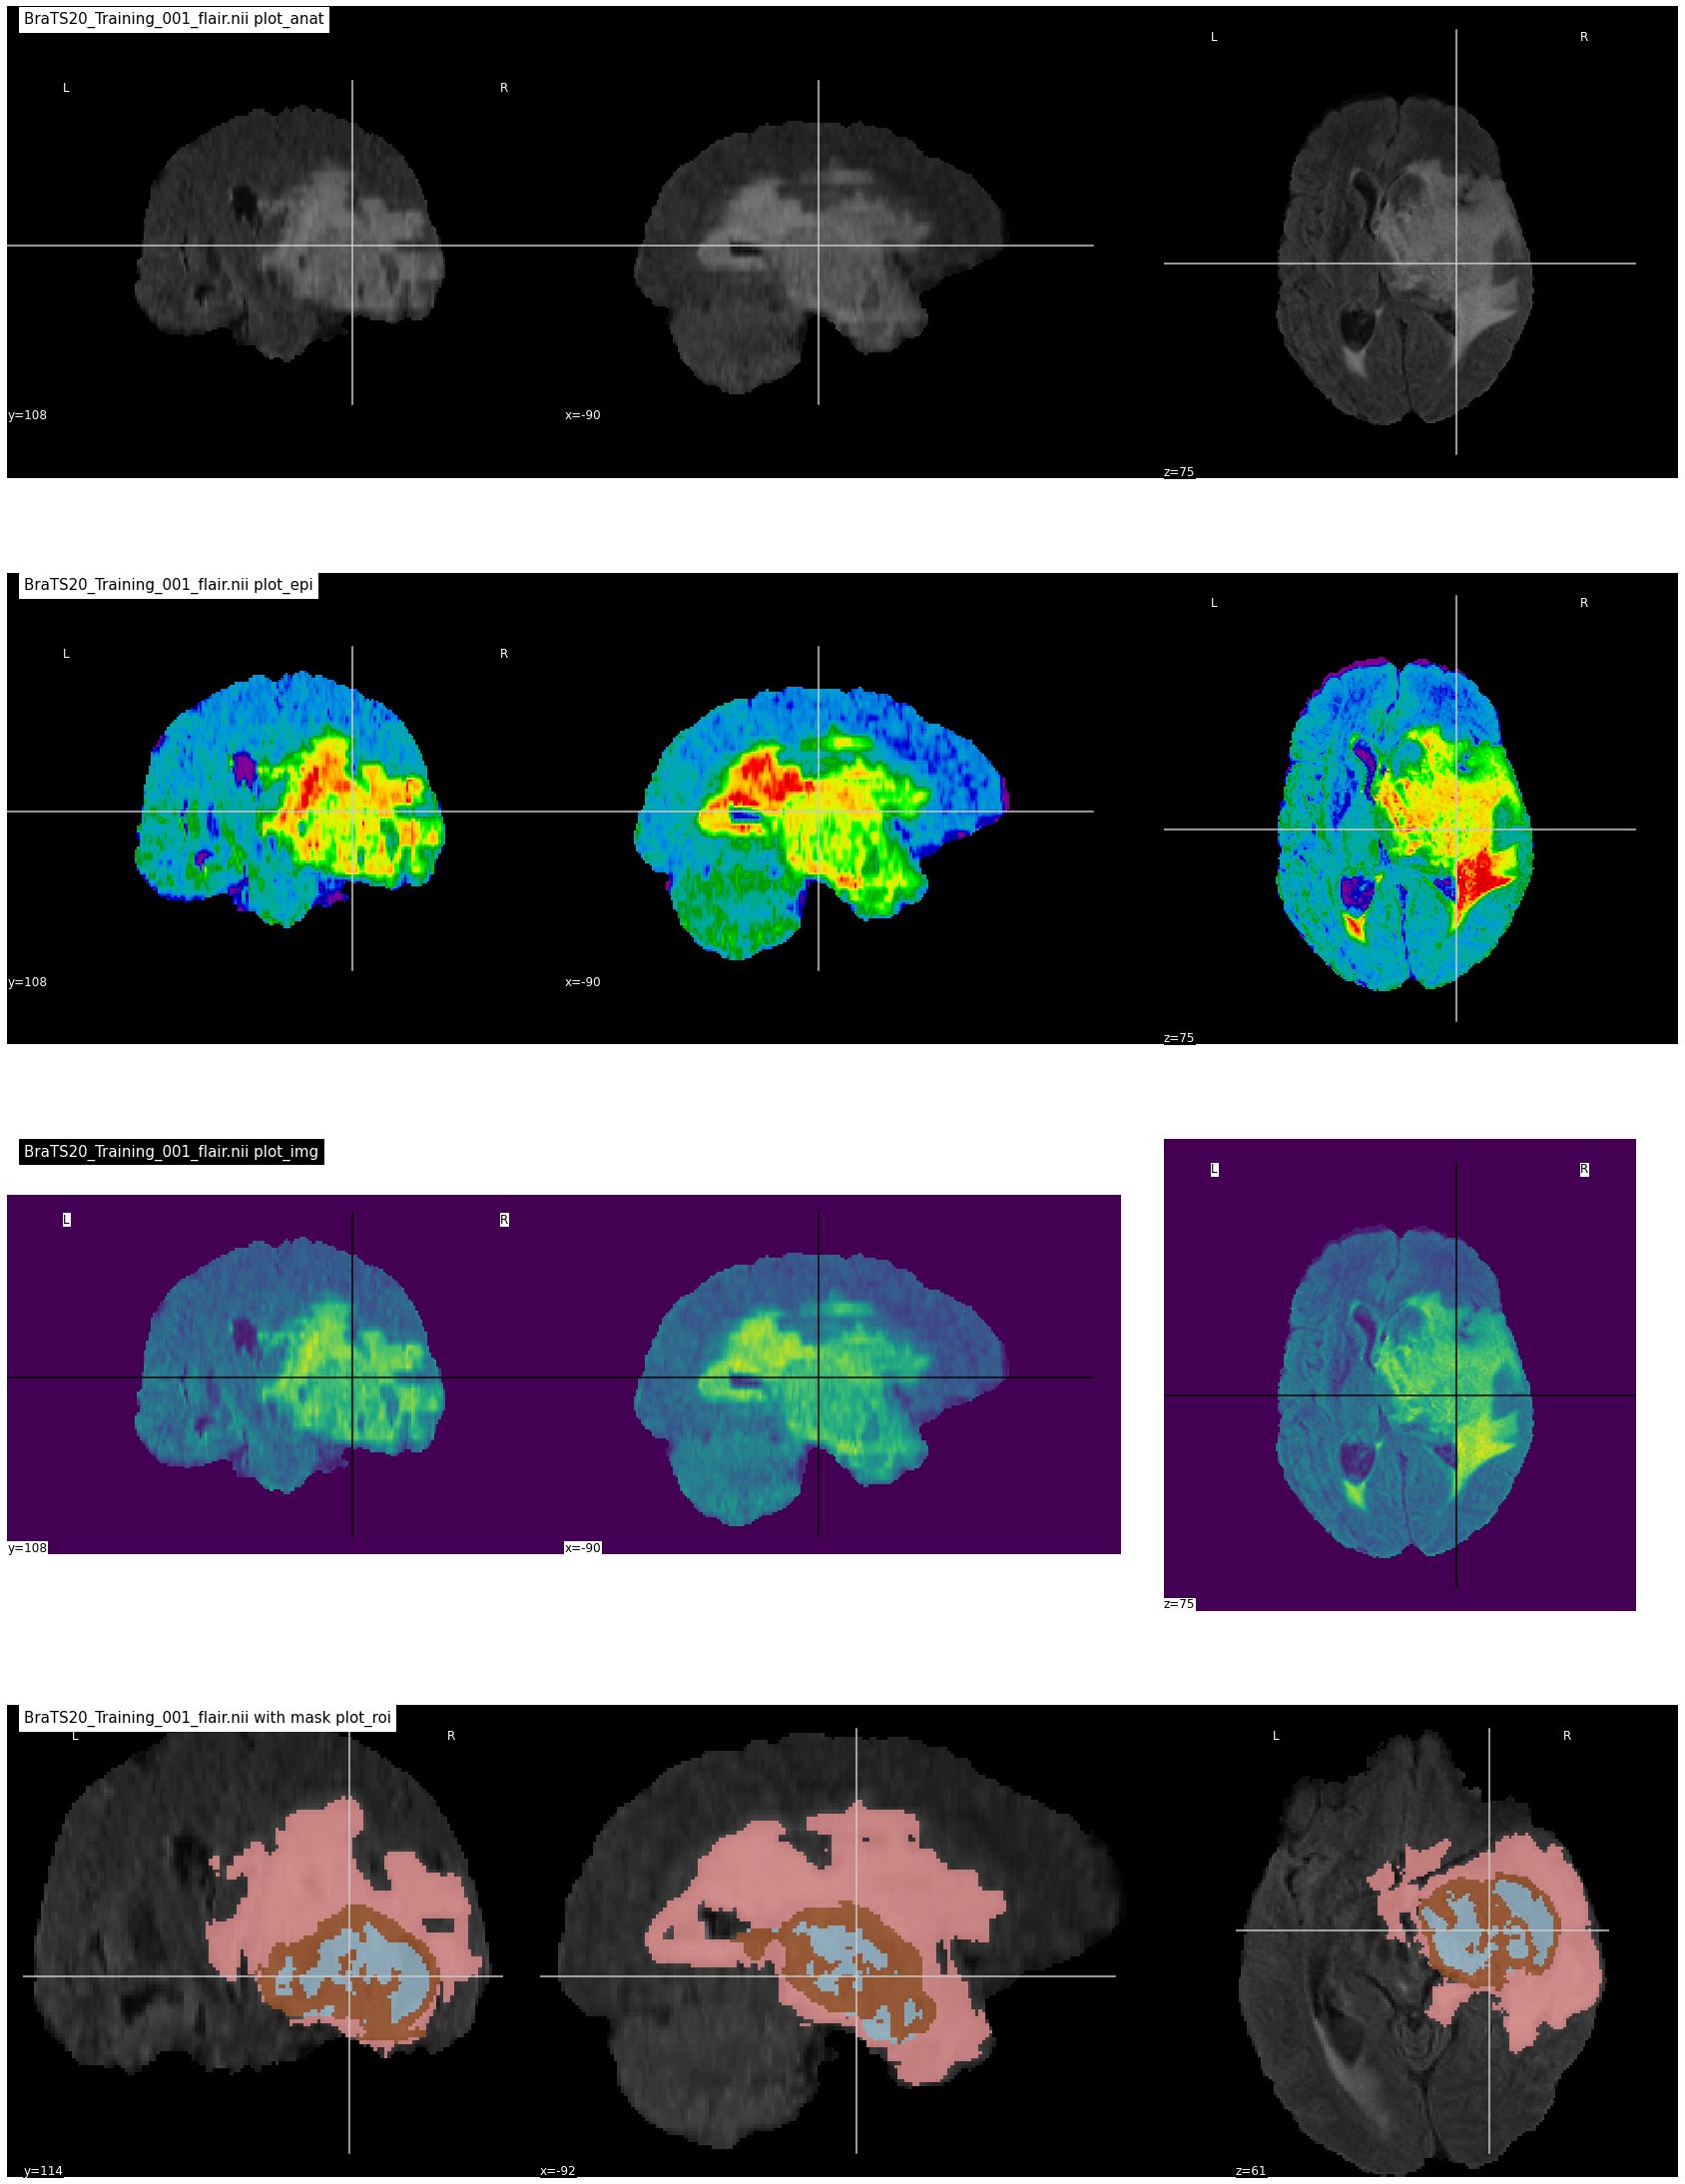

In [4]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [5]:

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


 
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
     
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [6]:
IMG_SIZE=128

In [2]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal

def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def build_model():
    size = 128
    num_filters = [16, 32, 48, 64]
    inputs = Input(shape=(size, size, 2))
    skip_x = []
    x = inputs

    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    for i, f, in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    x = Conv2D(4, (1, 1), padding="same",kernel_initializer=he_normal())(x)
    x = Activation("softmax")(x)

    return Model(inputs, x)


model = build_model()
model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing]) 


In [3]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 16)         304       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 128, 128, 16)         64        ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_19 (Activation)  (None, 128, 128, 16)         0         ['batch_normalization_18

 batch_normalization_26 (Ba  (None, 8, 8, 64)             256       ['conv2d_27[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_27 (Activation)  (None, 8, 8, 64)             0         ['batch_normalization_26[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 8, 8, 64)             36928     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_27 (Ba  (None, 8, 8, 64)             256       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
          

 concatenate_7 (Concatenate  (None, 128, 128, 48)         0         ['up_sampling2d_7[0][0]',     
 )                                                                   'activation_20[0][0]']       
                                                                                                  
 conv2d_35 (Conv2D)          (None, 128, 128, 16)         6928      ['concatenate_7[0][0]']       
                                                                                                  
 batch_normalization_34 (Ba  (None, 128, 128, 16)         64        ['conv2d_35[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_35 (Activation)  (None, 128, 128, 16)         0         ['batch_normalization_34[0][0]
                                                                    ']                            
          

# Load data


In [10]:

train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

**Override Keras sequence DataGenerator class**

In [11]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
       
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
        
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Number of data used**
for training / testing / validation

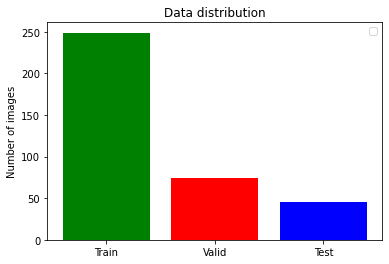

In [12]:

def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [37]:
csv_logger = CSVLogger('training1.log', separator=',', append=False)


callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

        csv_logger
    ]

# Train model


**Visualize the training process**

In [14]:
# history =  model.fit(training_generator,
#                     epochs=50,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= callbacks,
#                     validation_data = valid_generator
#                     )  
# model.save("../input/model_UNET_1.h5")

# Prediction examples 

4/4 [==============================] - 0s 40ms/step


<Figure size 1296x3600 with 0 Axes>

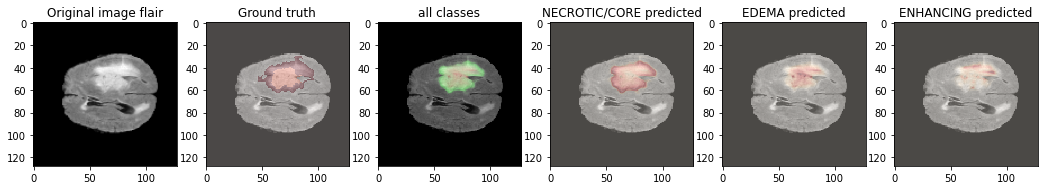

4/4 [==============================] - 0s 37ms/step


<Figure size 1296x3600 with 0 Axes>

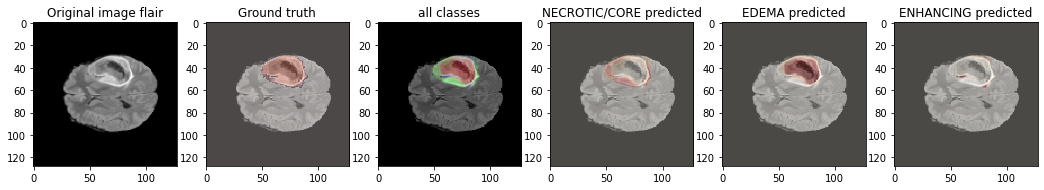

4/4 [==============================] - 0s 36ms/step


<Figure size 1296x3600 with 0 Axes>

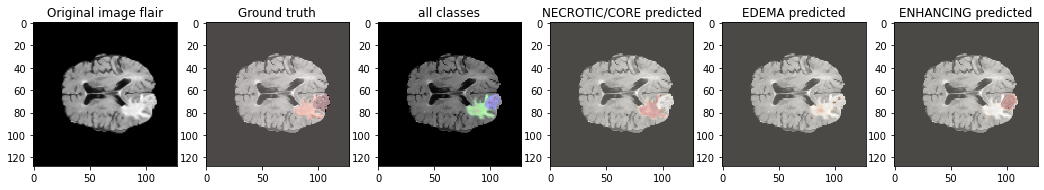

4/4 [==============================] - 0s 36ms/step


<Figure size 1296x3600 with 0 Axes>

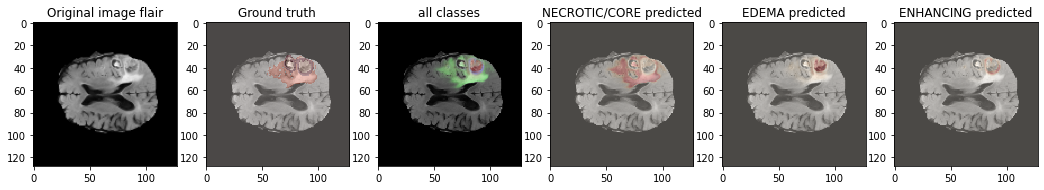

In [21]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 


    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    

showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])



# Evaluation

4/4 [==============================] - 0s 36ms/step


<Figure size 432x288 with 0 Axes>

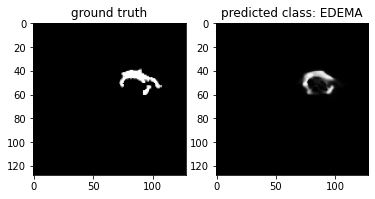

In [24]:
case = case=test_ids[1][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 
eval_class = 2



gt[gt != eval_class] = 1  

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [25]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
print("Evaluate on test data")
model.evaluate(test_generator, batch_size=100, callbacks= callbacks)


Evaluate on test data
45/45 [==============================] - 14s 287ms/step - loss: 0.0164 - accuracy: 0.9940 - mean_io_u_3: 0.8285 - dice_coef: 0.6231 - precision: 0.9942 - sensitivity: 0.9926 - specificity: 0.9981 - dice_coef_necrotic: 0.6606 - dice_coef_edema: 0.7607 - dice_coef_enhancing: 0.5698


[0.016560405492782593,
 0.9941169619560242,
 0.8310002088546753,
 0.6266536116600037,
 0.9943600296974182,
 0.9927529096603394,
 0.9980984330177307,
 0.6219321489334106,
 0.771240770816803,
 0.6303720474243164]

****U2NET****

In [31]:
import tensorflow as tf
from tensorflow.keras import layers

def Conv(x,out_ch=3,rate=1):
    x = layers.Conv2D(out_ch,3,padding='same',dilation_rate=1*rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def upsampling(src,tar):
    h = int(tar.shape[1]//src.shape[1])
    w = int(tar.shape[2]//src.shape[2])
    src = layers.UpSampling2D((h,w), interpolation='nearest')(src)
    return src
    
def en_1(x, mid_ch=12, out_ch=3):
    
    x0 = Conv(x,out_ch,1)
    x1 = Conv(x0,mid_ch,1)
    
    x = MaxPool2D(2, 2)(x1)
    x2 = Conv(x, mid_ch, 1)
   
    x = MaxPool2D(2, 2)(x2)
    x3 = Conv(x, mid_ch, 1)
    
    x = MaxPool2D(2, 2)(x3)
    x4 = Conv(x, mid_ch, 1)
    
    x = MaxPool2D(2, 2)(x4)
    x5 = Conv(x, mid_ch, 1)
    
    x = MaxPool2D(2, 2)(x5)
    x6 = Conv(x5, mid_ch, 1)

    x = Conv(x6, mid_ch, 2)
    
    x = Conv(tf.concat([x,x6],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x5)
    x = Conv(tf.concat([x,x5],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x4)
    x = Conv(tf.concat([x,x4],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x3)
    x = Conv(tf.concat([x,x3],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x2)
    x = Conv(tf.concat([x,x2],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x1)
    x = Conv(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def en_2(x, mid_ch=12, out_ch=3):
    
    x0 = Conv(x, out_ch, 1)    
    x1 = Conv(x0, mid_ch, 1)
    
    x = MaxPool2D(2, 2)(x1)
    x2 = Conv(x, mid_ch, 1)
    
    x = MaxPool2D(2, 2)(x2)
    x3 = Conv(x, mid_ch, 1)
    
    x = MaxPool2D(2, 2)(x3)
    x4 = Conv(x, mid_ch, 1)
    
    x = MaxPool2D(2, 2)(x4)
    x5 = Conv(x, mid_ch, 1)

    x = Conv(x, mid_ch, 2)

    x = Conv(tf.concat([x,x5],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x4)
    x = Conv(tf.concat([x,x4],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x3)
    x = Conv(tf.concat([x,x3],axis=-1), mid_ch, 1)
   
    x = upsampling(x,x2)
    x = Conv(tf.concat([x,x2],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x1)
    x = Conv(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def en_3(x, mid_ch=12, out_ch=3):
    
    x0 = Conv(x, out_ch, 1)    
    x1 = Conv(x0, mid_ch, 1)
    
    x = MaxPool2D(2, 2)(x1)
    x2 = Conv(x, mid_ch, 1)
    
    x = MaxPool2D(2, 2)(x2)
    x3 = Conv(x, mid_ch, 1)
    
    x = MaxPool2D(2, 2)(x3)
    x4 = Conv(x, mid_ch, 1)

    x = Conv(x, mid_ch, 2)

    x = Conv(tf.concat([x,x4],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x3)
    x = Conv(tf.concat([x,x3],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x2)
    x = Conv(tf.concat([x,x2],axis=-1), mid_ch, 1)
    
    x = upsampling(x,x1)
    x = Conv(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def en_4(x, mid_ch=12, out_ch=3):
    
    x0 = Conv(x, out_ch, 1)
    
    x1 = Conv(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = Conv(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = Conv(x, mid_ch, 1)

    x = Conv(x, mid_ch, 2)

    x = Conv(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = upsampling(x,x2)

    x = Conv(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = upsampling(x,x1)

    x = Conv(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def en_5(x, mid_ch=12, out_ch=3):

    x0 = Conv(x, out_ch, 1)
    
    x1 = Conv(x0, mid_ch, 1)
    x2 = Conv(x1, mid_ch, 2)
    x3 = Conv(x2, mid_ch, 4)
    
    x4 = Conv(x3, mid_ch, 8)
    
    x = Conv(tf.concat([x4,x3],axis=-1), mid_ch, 4)
    x = Conv(tf.concat([x,x2],axis=-1), mid_ch, 2)
    x = Conv(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def U2NET(x, out_ch=4):
    
    x1 = en_1(x, 32, 64)
    x = MaxPool2D(2, 2)(x1)

    x2 = en_2(x, 32, 128)
    x = MaxPool2D(2, 2)(x2)

    x3 = en_3(x, 64, 256)
    x = MaxPool2D(2, 2)(x3)

    x4 = en_4(x, 128, 512)
    x = MaxPool2D(2, 2)(x4)

    x5 = en_5(x, 256, 512)
    x = MaxPool2D(2, 2)(x5)

    x6 = en_5(x, 256, 512)
    x = upsampling(x6,x5)

    #decoder

    x5 = en_5(tf.concat([x,x5],axis=-1),256, 512)
    x = upsampling(x5,x4)

    x4 = en_4(tf.concat([x,x4],axis=-1),128, 256)
    x = upsampling(x4,x3)

    x3 = en_3(tf.concat([x,x3],axis=-1),64, 128)
    x = upsampling(x3,x2)

    x2 = en_2(tf.concat([x,x2],axis=-1),32, 64)
    x = upsampling(x2,x1)
    
    x1 = en_1(tf.concat([x,x1],axis=-1),16, 64)
    
    #Side output
    x = layers.ZeroPadding2D((1,1))(x1) 
    s1 = layers.Conv2D(out_ch, 3)(x)
    s1 = layers.Activation('softmax')(s1)

    x = layers.ZeroPadding2D((1,1))(x2) 
    x = layers.Conv2D(out_ch, 3)(x)
    s2 = upsampling(x,s1)
    s2 = layers.Activation('softmax')(s2)
    
    x = layers.ZeroPadding2D((1,1))(x3) 
    x = layers.Conv2D(out_ch, 3)(x)
    s3 = upsampling(x,s1)
    s3 = layers.Activation('softmax')(s3)
    
    x = layers.ZeroPadding2D((1,1))(x4) 
    x = layers.Conv2D(out_ch, 3)(x)
    s4 = upsampling(x,s1)
    s4 = layers.Activation('softmax')(s4)
    
    x = layers.ZeroPadding2D((1,1))(x5) 
    x = layers.Conv2D(out_ch, 3)(x)
    s5 = upsampling(x,s1)
    s5 = layers.Activation('softmax')(s5)
    
    x = layers.ZeroPadding2D((1,1))(x6) 
    x = layers.Conv2D(out_ch, 3)(x)
    s6 = upsampling(x,s1)
    s6 = layers.Activation('softmax')(s6)

    s0 = layers.Conv2D(out_ch, 1)(tf.concat([s1,s2,s3,s4,s5,s6],axis=-1))
    s0 = layers.Activation('softmax')(s0)

    return layers.add([s0,s1,s2,s3,s4,s5,s6])

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

uoutput = U2NET(input_layer)
model1 = Model(inputs = input_layer, outputs = uoutput) 
model1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )


In [32]:
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d_380 (Conv2D)             (None, 128, 128, 64) 1216        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_336 (BatchN (None, 128, 128, 64) 256         conv2d_380[0][0]                 
__________________________________________________________________________________________________
activation_357 (Activation)     (None, 128, 128, 64) 0           batch_normalization_336[0][0]    
____________________________________________________________________________________________

In [38]:

model1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )
history =  model1.fit(training_generator,
                    epochs=50,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )  

Epoch 1/50
249/249 [==============================] - 177s 703ms/step - loss: 0.0176 - accuracy: 0.9938 - mean_io_u_7: 0.8201 - dice_coef: 0.6252 - precision: 0.9945 - sensitivity: 0.9922 - specificity: 0.9981 - dice_coef_necrotic: 0.6093 - dice_coef_edema: 0.7325 - dice_coef_enhancing: 0.6898 - val_loss: 0.0188 - val_accuracy: 0.9936 - val_mean_io_u_7: 0.7787 - val_dice_coef: 0.6473 - val_precision: 0.9941 - val_sensitivity: 0.9921 - val_specificity: 0.9980 - val_dice_coef_necrotic: 0.6459 - val_dice_coef_edema: 0.7642 - val_dice_coef_enhancing: 0.7380
Epoch 2/50
249/249 [==============================] - 178s 714ms/step - loss: 0.0170 - accuracy: 0.9939 - mean_io_u_7: 0.8004 - dice_coef: 0.6352 - precision: 0.9945 - sensitivity: 0.9923 - specificity: 0.9981 - dice_coef_necrotic: 0.6455 - dice_coef_edema: 0.7407 - dice_coef_enhancing: 0.6838 - val_loss: 0.0186 - val_accuracy: 0.9937 - val_mean_io_u_7: 0.8218 - val_dice_coef: 0.6506 - val_precision: 0.9942 - val_sensitivity: 0.9922 - v

4/4 [==============================] - 0s 39ms/step


<Figure size 1296x3600 with 0 Axes>

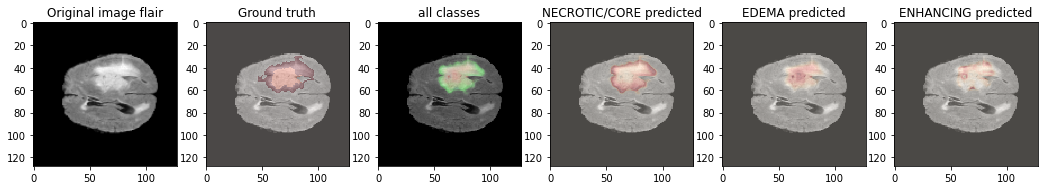

4/4 [==============================] - 0s 34ms/step


<Figure size 1296x3600 with 0 Axes>

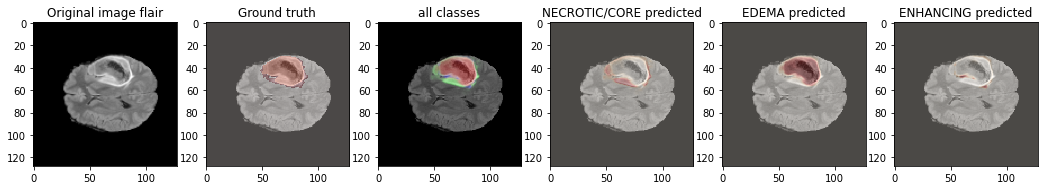

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

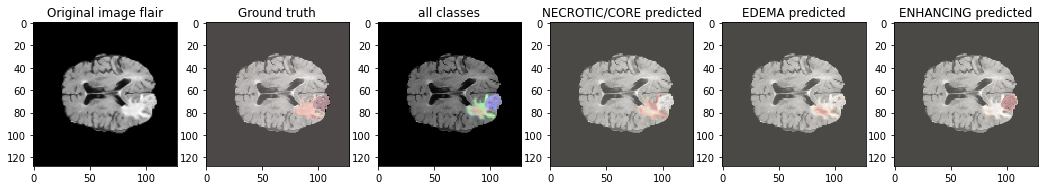

4/4 [==============================] - 0s 34ms/step


<Figure size 1296x3600 with 0 Axes>

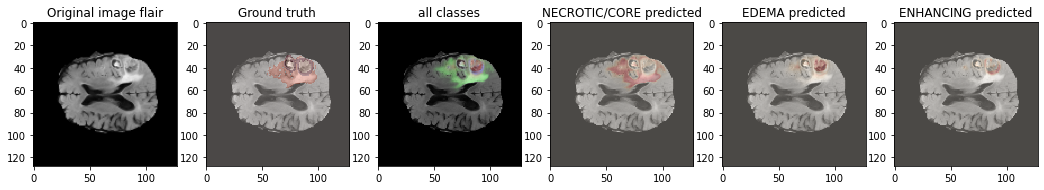

In [42]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 


    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model1.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    

showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])



4/4 [==============================] - 0s 36ms/step


<Figure size 432x288 with 0 Axes>

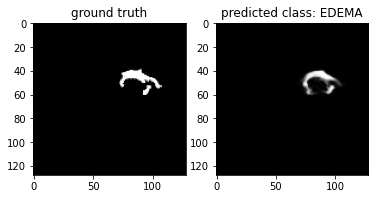

In [43]:
case = case=test_ids[1][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 
eval_class = 2 



gt[gt != eval_class] = 1 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [44]:
model1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
print("Evaluate on test data")
model1.evaluate(test_generator, batch_size=100, callbacks= callbacks)


Evaluate on test data
45/45 [==============================] - 28s 600ms/step - loss: 0.0186 - accuracy: 0.9934 - mean_io_u_8: 0.8628 - dice_coef: 0.6469 - precision: 0.9938 - sensitivity: 0.9920 - specificity: 0.9979 - dice_coef_necrotic: 0.6305 - dice_coef_edema: 0.7641 - dice_coef_enhancing: 0.6934


[0.01874934509396553,
 0.9935551285743713,
 0.860047459602356,
 0.6256632208824158,
 0.993884801864624,
 0.9922041893005371,
 0.9979392290115356,
 0.6077872514724731,
 0.7491804361343384,
 0.6250060796737671]